# LSTM

## Requirements
- python 3.7
- keras
- tensorflow
- scikit-learn
- matplotlib
- seaborn
- pandas
- numpy
- wandb

## Imports

In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

import wandb
from wandb.keras import WandbCallback

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, TimeDistributed, RepeatVector
from keras.optimizers import Adam

wandb.init(project="smartgrid-lstm-open")

Using TensorFlow backend.
wandb: WARNING Keras version 2.3.1 is not fully supported. Required keras >= 2.4.0
wandb: Currently logged in as: tyromijn (use `wandb login --relogin` to force relogin)


In [2]:
df = pd.read_csv('data/household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

df_resample = pd.DataFrame(columns=df.columns)

# global_active_power: household global minute-averaged active power (in kilowatt)
# global_reactive_power: household global minute-averaged reactive power (in kilowatt)
# voltage: minute-averaged voltage (in volt)
# global_intensity: household global minute-averaged current intensity (in ampere)

# df_resample['Global_active_power'] = np.cumsum(df['Global_active_power'].resample('h').mean())
# df_resample['Global_reactive_power'] = np.cumsum(df['Global_reactive_power'].resample('h').mean())
df_resample['Global_active_power'] = df['Global_active_power'].resample('h').mean()*1000
df_resample['Global_reactive_power'] = df['Global_reactive_power'].resample('h').mean()*1000
df_resample['Voltage'] = df['Voltage'].resample('h').mean()
df_resample['Global_intensity'] = df['Global_intensity'].resample('h').mean()

# sub_metering_#: energy sub-metering No. # (in watt-hour of active energy).
df_resample['Sub_metering_1'] = df['Sub_metering_1'].resample('h').sum()
df_resample['Sub_metering_2'] = df['Sub_metering_2'].resample('h').sum()
df_resample['Sub_metering_3'] = df['Sub_metering_3'].resample('h').sum()

df_resample.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.000000,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.000000,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.000000,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.000000,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.000000,0.416667,17.216667
2006-12-16 22:00:00,2.200133,0.056167,238.760000,9.523333,0.000000,0.133333,4.433333
2006-12-16 23:00:00,2.061600,0.071433,240.619667,8.896667,0.000000,0.083333,0.000000
2006-12-17 00:00:00,1.882467,0.102433,240.961833,8.126667,0.000000,0.466667,0.000000
2006-12-17 01:00:00,3.349400,0.136933,240.448333,14.246667,0.000000,25.233333,0.000000


In [3]:
# Fill NaN's with column's mean value
for j in range(0,7):        
        df_resample.iloc[:,j]=df_resample.iloc[:,j].fillna(df_resample.iloc[:,j].mean())

In [4]:
# scaler = MinMaxScaler()
# scaler.fit(df_resample)
# print(type(df_resample))
# df_resample = scaler.transform(df_resample)

In [5]:
columns = [x for x in df_resample.columns if x not in "Global_active_power"]
X, y = df_resample[columns].values, df_resample["Global_active_power"].values

# no. hours to forecast
n_forecasts = 8

# Shift X, y values
y = y[n_forecasts:]
future_X = X[len(X)-n_forecasts:]
df_future = df_resample[len(df_resample)-n_forecasts:]
X = X[:-n_forecasts]

df_pred = df_resample[:-n_forecasts]

# Set aside n_forecasts items to measure accuracy
forecast_X = X[-n_forecasts:]
forecast_y = y[-n_forecasts:]

df_pred = df_pred[-n_forecasts:]

# Split data
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=1)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.125, random_state=1) # 0.25 x 0.8 = 0.2

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
forecast_X = forecast_X.reshape((forecast_X.shape[0], 1, forecast_X.shape[1]))
future_X = future_X.reshape((future_X.shape[0], 1, future_X.shape[1]))

In [6]:
model = Sequential()
model.add(LSTM(256, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256, activation='relu', return_sequences=False))
model.add(Dense(1))
opt = Adam(learning_rate=0.0003)
model.compile(loss='mean_squared_error', optimizer=opt)



# model = Sequential()
# model.add(LSTM(200, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(RepeatVector(n_forecasts))
# model.add(LSTM(200, activation='relu', return_sequences=True))
# model.add(TimeDistributed(Dense(100, activation='relu')))
# model.add(TimeDistributed(Dense(1)))
# model.compile(loss='mse', optimizer='adam')

Train on 24206 samples, validate on 3458 samples
Epoch 1/100
24206/24206 [==============================] - 11s 459us/step - loss: 0.8091 - val_loss: 0.8294
Epoch 2/100
24206/24206 [==============================] - 10s 434us/step - loss: 0.7945 - val_loss: 0.8281
Epoch 3/100
24206/24206 [==============================] - 11s 442us/step - loss: 0.7919 - val_loss: 0.8360
Epoch 4/100
24206/24206 [==============================] - 11s 471us/step - loss: 0.7904 - val_loss: 0.8270
Epoch 5/100
24206/24206 [==============================] - 11s 438us/step - loss: 0.7875 - val_loss: 0.8283
Epoch 6/100
24206/24206 [==============================] - 11s 440us/step - loss: 0.7867 - val_loss: 0.8226
Epoch 7/100
24206/24206 [==============================] - 11s 445us/step - loss: 0.7858 - val_loss: 0.8372
Epoch 8/100
24206/24206 [==============================] - 10s 428us/step - loss: 0.7858 - val_loss: 0.8223
Epoch 9/100
24206/24206 [==============================] - 11s 452us/step - loss: 0.780

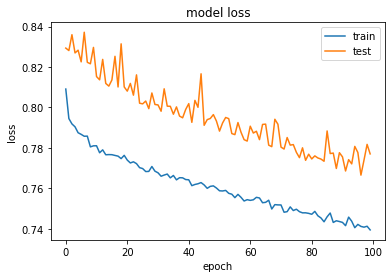

In [7]:
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=32, validation_data=(val_X, val_y), callbacks=[WandbCallback()])
model.save(os.path.join(wandb.run.dir, "model.h5"))

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [8]:
# make a prediction
yhat = model.predict(test_X)

# calculate RMSE 
rmse = np.sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.857


In [9]:
# forecast
pred_y = model.predict(forecast_X)
df_pred.index = df_pred.index + pd.Timedelta(8, unit='h')
df_pred['actual'] = forecast_y
df_pred['prediction'] = pred_y


future_pred_y = model.predict(future_X)
df_future['prediction'] = future_pred_y
df_future.index = df_future.index + pd.Timedelta(8, unit='h')

F:\Dev-Tools\envs\lstm\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


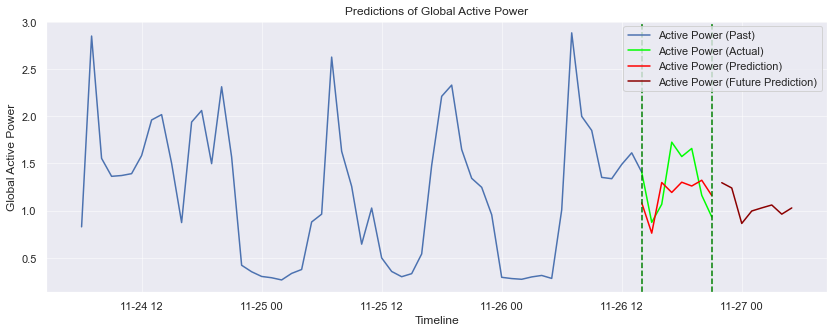

In [10]:
past = df_resample[-(48+n_forecasts*2):-n_forecasts+1]

sns.set(rc={'figure.figsize':(14,5)})
sns.lineplot(data=past, x=past.index, y="Global_active_power")
sns.lineplot(data=df_pred, x=df_pred.index, y="actual", color="lime")
sns.lineplot(data=df_pred, x=df_pred.index, y="prediction", color="red")
sns.lineplot(data=df_future, x=df_future.index, y="prediction", color="darkred")
plt.legend(['Active Power (Past)','Active Power (Actual)','Active Power (Prediction)', 'Active Power (Future Prediction)'])

plt.title('Predictions of Global Active Power')
plt.xlabel('Timeline')
plt.ylabel('Global Active Power')
plt.grid(which='major', color="#ffffff", alpha=.5)
plt.axvline(x=past.index[-1], color="green", linestyle="--")
plt.axvline(x=df_pred.index[-1], color="green", linestyle="--")

In [11]:
df_pred

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,actual,prediction
dt,,,,,,,,,
2010-11-26 14:00:00,1.008767,0.047033,243.329833,4.243333,0.0,0.000000,4.950000,1.407767,1.083341
2010-11-26 15:00:00,2.883933,0.102833,238.316833,12.050000,0.2,0.450000,17.433333,0.876433,0.762061
2010-11-26 16:00:00,1.999300,0.113833,239.721667,8.333333,8.9,0.683333,17.633333,1.067933,1.298747
2010-11-26 17:00:00,1.849967,0.063500,239.980167,7.690000,8.9,0.000000,17.666667,1.725900,1.193288
2010-11-26 18:00:00,1.352767,0.089800,238.862333,5.586667,0.0,0.000000,17.516667,1.573467,1.301632
2010-11-26 19:00:00,1.338900,0.107767,238.002167,5.580000,0.0,0.366667,17.383333,1.659333,1.261550
2010-11-26 20:00:00,1.490200,0.094200,237.943333,6.243333,0.0,0.800000,17.366667,1.163700,1.322572
2010-11-26 21:00:00,1.612933,0.206533,238.550333,6.880000,0.0,0.000000,17.466667,0.934667,1.161187
